# 2. CNN-LSTM Model Training and Evaluation

This notebook covers the end-to-end process of training and evaluating the CNN-LSTM model for Bitcoin price forecasting.

**Steps:**
1. **Load Data**: Load the processed dataset containing prices, on-chain metrics, and technical indicators.
2. **Data Exploration**: Briefly visualize key features.
3. **Preprocessing**: Normalize and create sequences for the time-series model.
4. **Model Definition**: Instantiate the CNN-LSTM model.
5. **Training**: Train the model on the training dataset and validate it.
6. **Evaluation**: Evaluate the model's performance on the test set and visualize the results.

### 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import sys
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Add project root to path to import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models.cnn_lstm import CNNLSTM

plt.style.use('seaborn-v0_8-darkgrid')

# Load the dataset
file_path = '../data/processed/btc_with_indicators.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df.set_index('date', inplace=True)

print('Dataset loaded successfully.')
df.head()

Dataset loaded successfully.


,open,high,low,close,volume,symbol,source,download_timestamp_market,asset,adractcnt,...,txcnt,download_timestamp_onchain,sma_20,ema_20,rsi_14,macd,macd_signal,bb_upper,bb_lower,bb_width
date,,,,,,,,,,,,,,,,,,,,,
2024-08-17,58888.99,59711.02,58803.45,59497.49,2787.563556,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,612305,...,706066,2025-06-29 17:05:04.117435,60254.8035,60403.007031,45.622968,-1471.243728,-1648.752168,67018.988212,53490.618788,13528.369424
2024-08-18,59497.49,60284.99,58422.00,58437.90,4325.648172,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,588717,...,758170,2025-06-29 17:05:04.117435,59838.1260,60215.853981,43.087997,-1448.294115,-1608.660557,65939.486964,53736.765036,12202.721927
2024-08-19,58436.20,59639.81,57820.00,59452.67,8539.293787,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,687027,...,560243,2025-06-29 17:05:04.117435,59502.2755,60143.169792,46.172655,-1332.858559,-1553.500158,64867.666765,54136.884235,10730.782531
2024-08-20,59455.81,61457.03,58571.96,59017.59,11062.052799,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,696903,...,715687,2025-06-29 17:05:04.117435,59222.6740,60035.971717,45.045355,-1261.935562,-1495.187238,64050.168782,54395.179218,9654.989565
2024-08-21,59017.59,61849.98,58793.89,61163.28,13380.111017,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,711700,...,684872,2025-06-29 17:05:04.117435,59016.4290,60143.334410,51.353332,-1020.821925,-1400.314176,63082.099375,54950.758625,8131.340750


### 2. Data Exploration

In [2]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 2024-08-17 to 2025-06-28
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   open                        316 non-null    float64
 1   high                        316 non-null    float64
 2   low                         316 non-null    float64
 3   close                       316 non-null    float64
 4   volume                      316 non-null    float64
 5   symbol                      316 non-null    object 
 6   source                      316 non-null    object 
 7   download_timestamp_market   316 non-null    object 
 8   asset                       316 non-null    object 
 9   adractcnt                   316 non-null    int64  
 10  feetotntv                   316 non-null    float64
 11  txcnt                       316 non-null    int64  
 12  download_timestamp_onchain  316 non-null    object 
 13  sma_20          

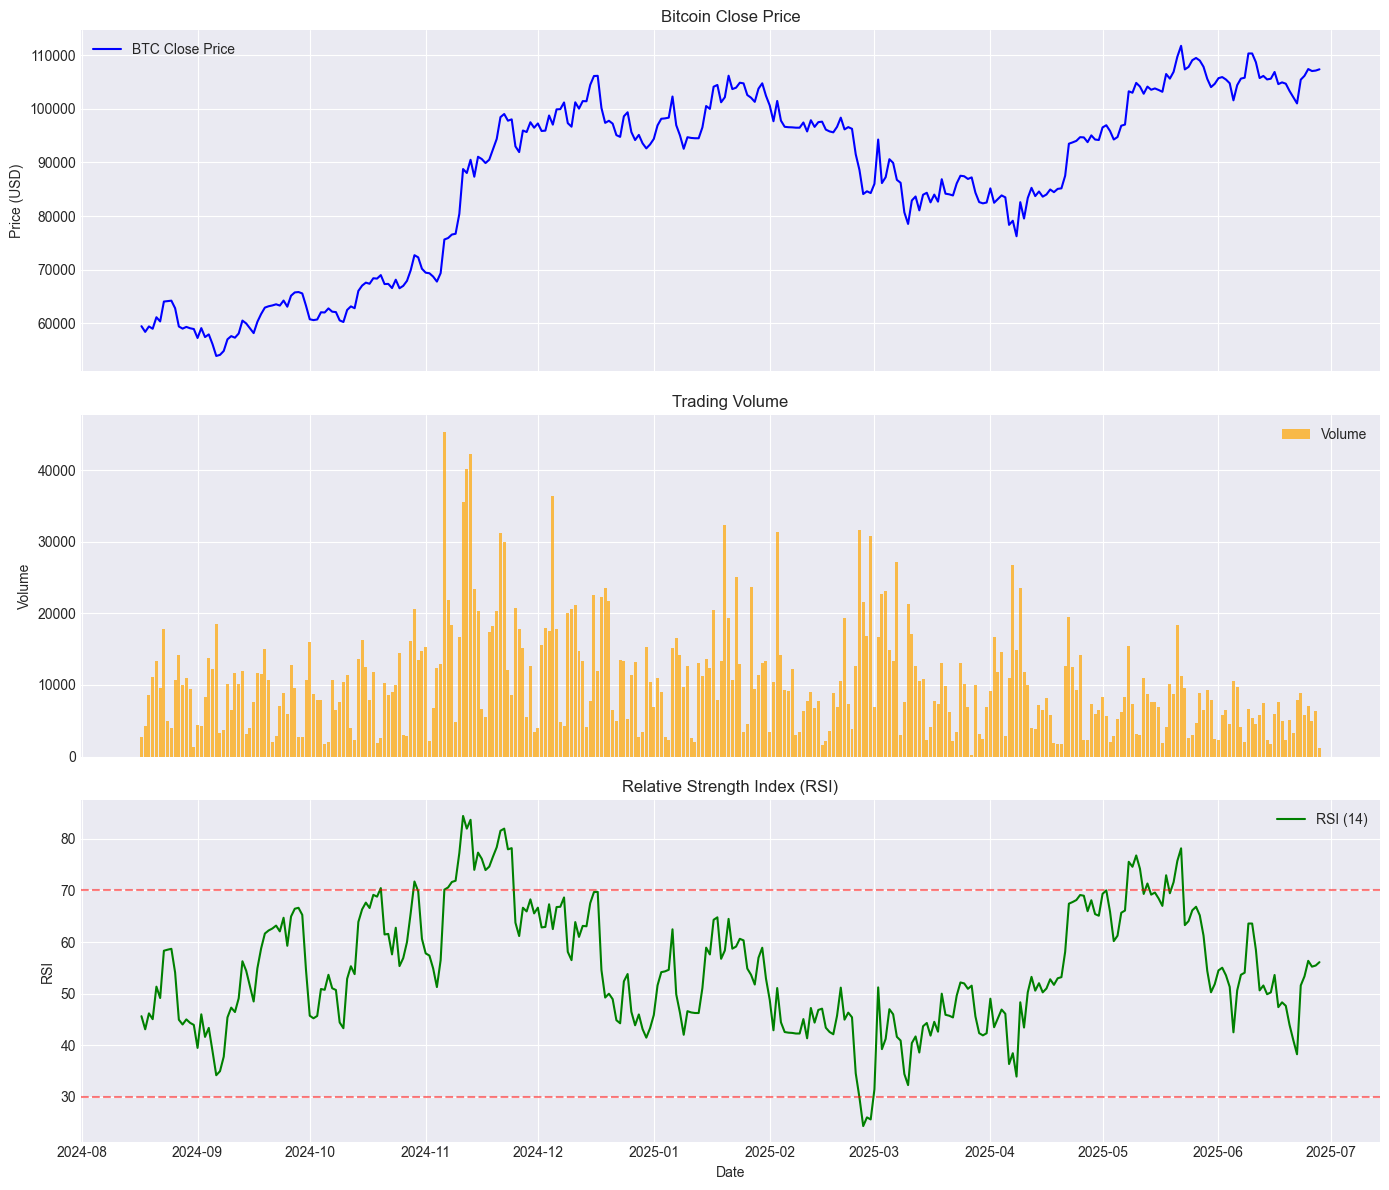

In [3]:
# Visualize key features
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Close Price
axes[0].plot(df.index, df['close'], label='BTC Close Price', color='blue')
axes[0].set_title('Bitcoin Close Price')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Plot Trading Volume
axes[1].bar(df.index, df['volume'], label='Volume', color='orange', alpha=0.7)
axes[1].set_title('Trading Volume')
axes[1].set_ylabel('Volume')
axes[1].legend()

# Plot RSI
axes[2].plot(df.index, df['rsi_14'], label='RSI (14)', color='green')
axes[2].axhline(70, linestyle='--', color='red', alpha=0.5) # Overbought
axes[2].axhline(30, linestyle='--', color='red', alpha=0.5) # Oversold
axes[2].set_title('Relative Strength Index (RSI)')
axes[2].set_ylabel('RSI')
axes[2].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### 3. Data Preprocessing

In [4]:
# Define features and target
feature_cols = [
    'open', 'high', 'low', 'close', 'volume', # Market
    'adractcnt', 'txcnt', 'feetotntv',      # On-chain
    'sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'bb_width' # Indicators
]
target_col = 'close'

# Normalize the data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[feature_cols].iloc[i:i + window_size].values)
        y.append(data[target_col].iloc[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df_scaled, window_size)

# Split data (70% train, 15% val, 15% test)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (200, 30, 16)
y_train shape: (200,)
X_val shape: (42, 30, 16)
X_test shape: (44, 30, 16)


In [5]:
# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # Reshape y_train to be 2D (batch_size, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### 4. Model Training

In [6]:
# Model parameters
num_features = len(feature_cols)
model = CNNLSTM(num_features=num_features, window_size=window_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20 # Using a smaller number for quick demonstration

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch [1/20], Train Loss: 0.182144, Val Loss: 0.318908
Epoch [2/20], Train Loss: 0.025731, Val Loss: 0.150274
Epoch [3/20], Train Loss: 0.010547, Val Loss: 0.154464
Epoch [4/20], Train Loss: 0.012345, Val Loss: 0.096452
Epoch [5/20], Train Loss: 0.005043, Val Loss: 0.051649
Epoch [6/20], Train Loss: 0.003844, Val Loss: 0.048794
Epoch [7/20], Train Loss: 0.004382, Val Loss: 0.020554
Epoch [8/20], Train Loss: 0.002523, Val Loss: 0.015572
Epoch [9/20], Train Loss: 0.002659, Val Loss: 0.007444
Epoch [10/20], Train Loss: 0.002355, Val Loss: 0.004662
Epoch [11/20], Train Loss: 0.002034, Val Loss: 0.004565
Epoch [12/20], Train Loss: 0.002073, Val Loss: 0.003045
Epoch [13/20], Train Loss: 0.004544, Val Loss: 0.003580
Epoch [14/20], Train Loss: 0.003033, Val Loss: 0.003305
Epoch [15/20], Train Loss: 0.002146, Val Loss: 0.002894
Epoch [16/20], Train Loss: 0.004242, Val Loss: 0.007204
Epoch [17/20], Train Loss: 0.002818, Val Loss: 0.004436
Epoch [18/20], Train Loss: 0.001966, Val Loss: 0.004433
E

### 5. Evaluation

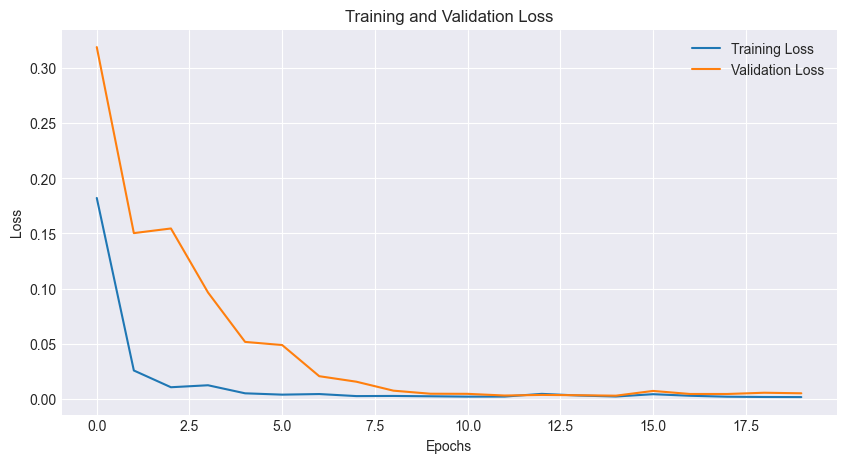

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_lstm_training_loss.png')
plt.show()

In [8]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_t)

# Inverse transform predictions to original scale
# Create a dummy array with the same shape as the original features
dummy_features = np.zeros((len(test_predictions), len(feature_cols)))
# Place predictions into the 'close' column index
close_idx = feature_cols.index('close')
dummy_features[:, close_idx] = test_predictions.numpy().flatten()
inversed_predictions = scaler.inverse_transform(dummy_features)[:, close_idx]

# Inverse transform actual values
dummy_features[:, close_idx] = y_test_t.numpy().flatten()
inversed_actuals = scaler.inverse_transform(dummy_features)[:, close_idx]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inversed_actuals, inversed_predictions))
mae = mean_absolute_error(inversed_actuals, inversed_predictions)
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')

Test RMSE: 5572.89
Test MAE: 5226.84


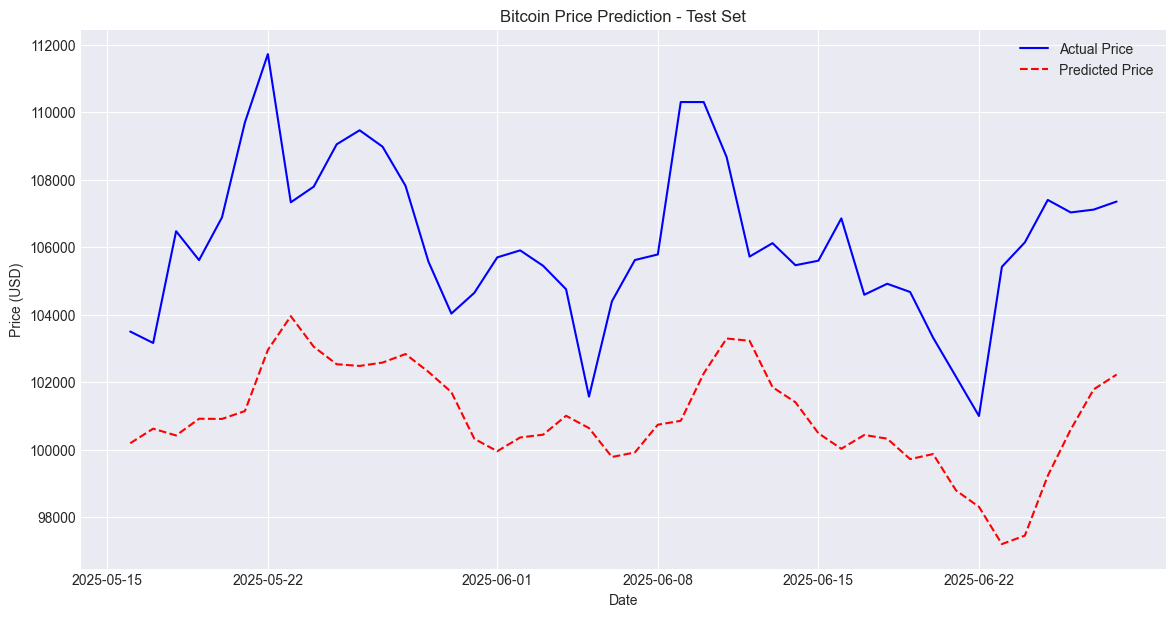

In [9]:
# Visualize predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(inversed_actuals):], inversed_actuals, label='Actual Price', color='blue')
plt.plot(df.index[-len(inversed_predictions):], inversed_predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('Bitcoin Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
# save the plot
plt.savefig('../figures/cnn_lstm_btc_price_prediction_test.png')
plt.show()

# Thoughts

1. Improve Responsiveness to Spikes:

    •	We will add volatility indicators like ATR (Average True Range)

	•	We will include lagged returns (e.g., % change in price from previous day)
	
    •	We will consider external features: news sentiment, macro data -> in the next notebooks as described in proposal.


2. Model Complexity:

    •	We might use Bidirectional LSTM to see past and future in the same window

    •	We might use Attention Mechanisms to weigh more relevant time steps

    •	We might combine predictions with exogenous models (e.g., ARIMAX + LSTM)


 3. Evaluation Enhancements

	•	To better analyze model performance, we will plot residuals (prediction - actual) to spot bias.

	•	We will use R² score to measure variance explained.

    •	We will use directional accuracy: how often does the model get the trend direction right?

# Iteration after observing results and thinking (above):

Let's add ATR and Lagged Returns (change in price over the last day)

In [10]:
# 1. Compute True Range (TR)
df['prev_close'] = df['close'].shift(1)
df['tr1'] = df['high'] - df['low']
df['tr2'] = (df['high'] - df['prev_close']).abs()
df['tr3'] = (df['low']  - df['prev_close']).abs()
df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)

# 2. Compute ATR = rolling mean of true_range
df['atr_14'] = df['true_range'].rolling(window=14).mean()

# 3. Compute Lagged Returns
df['ret_1d'] = df['close'].pct_change(periods=1)

In [11]:
df.head()

,open,high,low,close,volume,symbol,source,download_timestamp_market,asset,adractcnt,...,bb_upper,bb_lower,bb_width,prev_close,tr1,tr2,tr3,true_range,atr_14,ret_1d
date,,,,,,,,,,,,,,,,,,,,,
2024-08-17,58888.99,59711.02,58803.45,59497.49,2787.563556,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,612305,...,67018.988212,53490.618788,13528.369424,NaN,907.57,NaN,NaN,907.57,NaN,NaN
2024-08-18,59497.49,60284.99,58422.00,58437.90,4325.648172,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,588717,...,65939.486964,53736.765036,12202.721927,59497.49,1862.99,787.50,1075.49,1862.99,NaN,-0.017809
2024-08-19,58436.20,59639.81,57820.00,59452.67,8539.293787,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,687027,...,64867.666765,54136.884235,10730.782531,58437.90,1819.81,1201.91,617.90,1819.81,NaN,0.017365
2024-08-20,59455.81,61457.03,58571.96,59017.59,11062.052799,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,696903,...,64050.168782,54395.179218,9654.989565,59452.67,2885.07,2004.36,880.71,2885.07,NaN,-0.007318
2024-08-21,59017.59,61849.98,58793.89,61163.28,13380.111017,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,711700,...,63082.099375,54950.758625,8131.340750,59017.59,3056.09,2832.39,223.70,3056.09,NaN,0.036357


In [12]:
# Let's add the new features to the feature set
feature_cols += ['atr_14', 'ret_1d']

In [13]:
# Normalize
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

In [14]:
# Remove rows with NaN values in the new feature set and target column
df_scaled = df_scaled.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

In [15]:
# Create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[feature_cols].iloc[i:i + window_size].values)
        y.append(data[target_col].iloc[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df_scaled, window_size)

# Split data (70% train, 15% val, 15% test)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (191, 30, 18)
y_train shape: (191,)
X_val shape: (40, 30, 18)
X_test shape: (42, 30, 18)


In [16]:
# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # Reshape y_train to be 2D (batch_size, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
# Model parameters
num_features = len(feature_cols)
model = CNNLSTM(num_features=num_features, window_size=window_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20 # Using a smaller number for quick demonstration

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch [1/20], Train Loss: 0.196097, Val Loss: 0.368318
Epoch [2/20], Train Loss: 0.020185, Val Loss: 0.207113
Epoch [3/20], Train Loss: 0.006843, Val Loss: 0.195165
Epoch [4/20], Train Loss: 0.011401, Val Loss: 0.145359
Epoch [5/20], Train Loss: 0.005419, Val Loss: 0.084707
Epoch [6/20], Train Loss: 0.004427, Val Loss: 0.069280
Epoch [7/20], Train Loss: 0.003667, Val Loss: 0.037464
Epoch [8/20], Train Loss: 0.002959, Val Loss: 0.012626
Epoch [9/20], Train Loss: 0.002392, Val Loss: 0.008968
Epoch [10/20], Train Loss: 0.002517, Val Loss: 0.006402
Epoch [11/20], Train Loss: 0.001989, Val Loss: 0.002098
Epoch [12/20], Train Loss: 0.002175, Val Loss: 0.002591
Epoch [13/20], Train Loss: 0.001450, Val Loss: 0.002030
Epoch [14/20], Train Loss: 0.001784, Val Loss: 0.001169
Epoch [15/20], Train Loss: 0.001463, Val Loss: 0.001264
Epoch [16/20], Train Loss: 0.001601, Val Loss: 0.001316
Epoch [17/20], Train Loss: 0.001477, Val Loss: 0.001246
Epoch [18/20], Train Loss: 0.001741, Val Loss: 0.001308
E

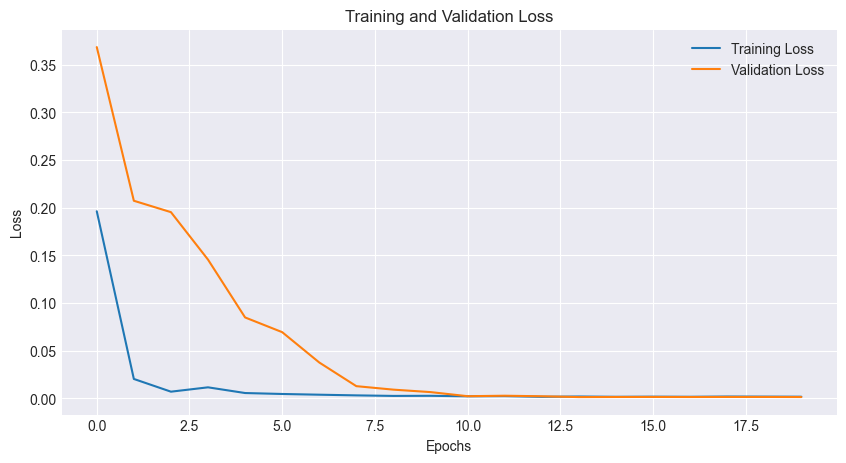

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_lstm_training_loss_it01.png')
plt.show()

In [19]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_t)

# Inverse transform predictions to original scale
# Create a dummy array with the same shape as the original features
dummy_features = np.zeros((len(test_predictions), len(feature_cols)))
# Place predictions into the 'close' column index
close_idx = feature_cols.index('close')
dummy_features[:, close_idx] = test_predictions.numpy().flatten()
inversed_predictions = scaler.inverse_transform(dummy_features)[:, close_idx]

# Inverse transform actual values
dummy_features[:, close_idx] = y_test_t.numpy().flatten()
inversed_actuals = scaler.inverse_transform(dummy_features)[:, close_idx]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inversed_actuals, inversed_predictions))
mae = mean_absolute_error(inversed_actuals, inversed_predictions)
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')

Test RMSE: 4018.65
Test MAE: 3538.53


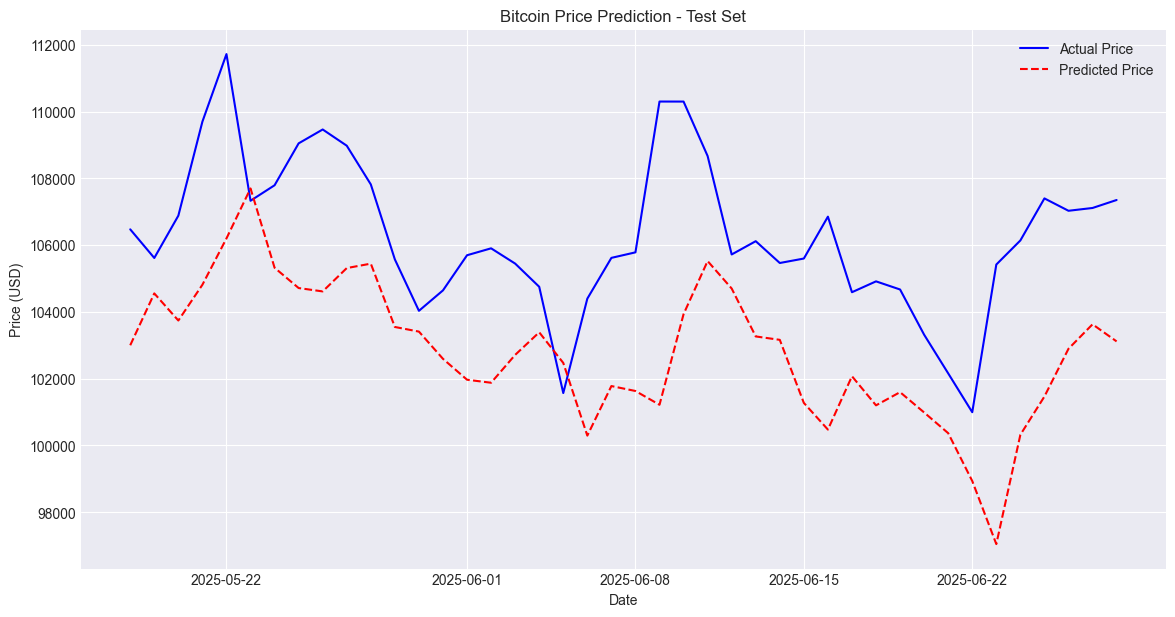

In [20]:
# Visualize predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(inversed_actuals):], inversed_actuals, label='Actual Price', color='blue')
plt.plot(df.index[-len(inversed_predictions):], inversed_predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('Bitcoin Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
# save the plot
plt.savefig('../figures/cnn_lstm_btc_price_prediction_test_iter01.png')
plt.show()

# Thoughts:

Adding the ATR actually improved the result a bit. The predictions are closer and more reactive to the price fluctuations.

This got me thinking (which I guess I should have thought about before), that we needed to actually see the permutation effect of the features.

In [21]:
import numpy as np
import torch

# 1.1 Get baseline predictions & MSE
model.eval()
with torch.no_grad():
    y_pred_base = model(X_test_t).squeeze().numpy()
baseline_mse = np.mean((y_pred_base - y_test) ** 2)

In [22]:
# Baseline MSE
model.eval()
with torch.no_grad():
    y_base = model(X_test_t).squeeze().numpy()
baseline_mse = np.mean((y_base - y_test)**2)

n_repeats = 5
importances = {f: [] for f in feature_cols}

for feat_idx, feat in enumerate(feature_cols):
    for _ in range(n_repeats):
        Xp = X_test.copy()
        flat = Xp[:,:,feat_idx].reshape(-1)
        np.random.shuffle(flat)
        Xp[:,:,feat_idx] = flat.reshape(Xp.shape[0], Xp.shape[1])
        
        with torch.no_grad():
            y_pred = model(torch.tensor(Xp, dtype=torch.float32)).squeeze().numpy()
        perm_mse = np.mean((y_pred - y_test)**2)
        importances[feat].append(perm_mse - baseline_mse)

# Average across repeats
avg_importance = {f: np.mean(deltas) for f, deltas in importances.items()}

# Sort highest to lowest
sorted_imp = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
for feat, delta in sorted_imp:
    print(f"{feat} → ΔMSE = {delta}")

bb_lower → ΔMSE = 0.0012866125211139171
high → ΔMSE = 0.0009798140859841264
ema_20 → ΔMSE = 0.000957166757288913
macd → ΔMSE = 0.0009462201871918643
open → ΔMSE = 0.0004996334677631586
close → ΔMSE = 0.00048404784645029384
low → ΔMSE = 0.0004015955434395438
sma_20 → ΔMSE = 0.00010233044021211844
ret_1d → ΔMSE = 8.462826761773505e-05
feetotntv → ΔMSE = 2.5738509306335275e-05
atr_14 → ΔMSE = 2.200397324963327e-05
volume → ΔMSE = 9.193968059807017e-06
bb_upper → ΔMSE = -0.00011218945411083508
txcnt → ΔMSE = -0.00014716892851448677
macd_signal → ΔMSE = -0.0004247025867309677
adractcnt → ΔMSE = -0.0004992673249857463
bb_width → ΔMSE = -0.0006918643498774522
rsi_14 → ΔMSE = -0.0008781957981239795
